In [1]:
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 15.3 시계열 예측하기

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size,1)
    time = np.linspace(0,1,n_steps)
    series = 0.5 * np.sin((time-offsets1) * (freq1 * 10+10))
    series += 0.2 * np.sin((time-offsets2) * (freq2*20+20))
    series += 0.1 *(np.random.rand(batch_size, n_steps) - 0.5)
    return series[..., np.newaxis].astype(np.float32)

In [3]:
np.random.seed(42)
n_steps = 50
series = generate_time_series(10000, n_steps+1)
X_train, y_train = series[:7000, :n_steps] ,series[:7000,-1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000,-1]
X_test, y_test = series[9000:, :n_steps], series[9000:,-1]

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

Saving figure time_series_plot


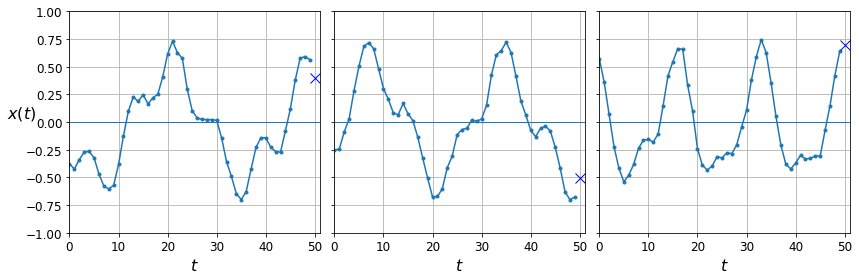

In [5]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
save_fig("time_series_plot")
plt.show()

## 15.3.1 기준성능
### naive prediction

In [6]:
y_pred = X_valid[:,-1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

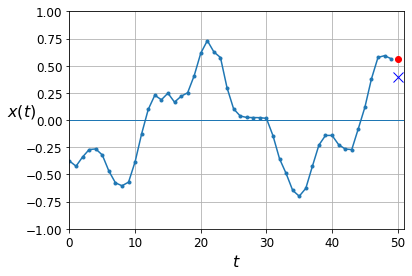

In [7]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Linear predictions

In [12]:
# np.random.seed(42)
# tf.random.set_seed(42)

# model = keras.models.Sequential([
#     keras.layers.Flatten(input_shape=[50,1]),
#     keras.layers.Dense(1)
# ])

# model.compile(loss="mse", optimizer="adam")
# history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

In [13]:
model = keras.models.load_model("sequence_naive_prediction.h5")

In [14]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 1ms/step - loss: 0.0042


0.004168085753917694

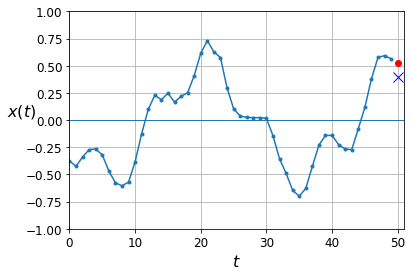

In [15]:

y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [16]:
model.save("sequence_naive_prediction.h5")

## 15.3.2 간단한 RNN 구현하기

In [18]:
# model = keras.models.Sequential([
#     keras.layers.SimpleRNN(1, input_shape=[None,1])
# ])

# optimizer = keras.optimizers.Adam(lr=0.005)
# model.compile(loss="mse", optimizer=optimizer)
# history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 7s 33ms/step - loss: 0.1003 - val_loss: 0.0455
Epoch 2/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0352 - val_loss: 0.0285
Epoch 3/20
219/219 [==============================] - 7s 33ms/step - loss: 0.0246 - val_loss: 0.0212
Epoch 4/20
219/219 [==============================] - 7s 33ms/step - loss: 0.0194 - val_loss: 0.0173
Epoch 5/20
219/219 [==============================] - 7s 34ms/step - loss: 0.0163 - val_loss: 0.0149
Epoch 6/20
219/219 [==============================] - 7s 34ms/step - loss: 0.0144 - val_loss: 0.0132
Epoch 7/20
219/219 [==============================] - 7s 33ms/step - loss: 0.0131 - val_loss: 0.0122
Epoch 8/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0123 - val_loss: 0.0115
Epoch 9/20
219/219 [==============================] - 7s 34ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 7s 34ms/step - loss: 0.0115 - val_lo

In [21]:
model = keras.models.load_model("sequence_simpleRNN.h5")

In [22]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 4ms/step - loss: 0.0109


0.01088297925889492

In [23]:
model.save("sequence_simpleRNN.h5")

## 15.3.3 심층 RNN

In [24]:
# model = keras.models.Sequential([
#     keras.layers.SimpleRNN(20,return_sequences=True, input_shape=[None,1]),
#     keras.layers.SimpleRNN(20),
#     keras.layers.Dense(1)
# ])
# model.compile(loss="mse", optimizer="adam")
# history = model.fit(X_train, y_train, epochs=20,
#                     validation_data=(X_valid, y_valid))

# model.save("sequence_simpleDeepRNN.h5")

Epoch 1/20
219/219 [==============================] - 16s 74ms/step - loss: 0.0096 - val_loss: 0.0038
Epoch 2/20
219/219 [==============================] - 16s 75ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 3/20
219/219 [==============================] - 16s 74ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 4/20
219/219 [==============================] - 16s 71ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 5/20
219/219 [==============================] - 16s 73ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 6/20
219/219 [==============================] - 16s 71ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 7/20
219/219 [==============================] - 15s 71ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 8/20
219/219 [==============================] - 15s 69ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 16s 75ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 10/20
219/219 [==============================] - 16s 72ms/step - loss: 0.002

In [26]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 7ms/step - loss: 0.0025


0.0024769383016973734

In [28]:
model = keras.models.load_model("sequence_simpleDeepRNN.h5")
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 7ms/step - loss: 0.0025


0.0024769383016973734

## 15.3.4 여러 타임 스텝 앞을 예측하기

다음 값을 예측하고 이 값을 예측으로 추가

In [29]:
np.random.seed(43)

series = generate_time_series(1,n_steps+10)
X_new, Y_new = series[:,:n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:,np.newaxis,:]
    X = np.concatenate([X,y_pred_one], axis=1)

Y_pred = X[:,n_steps:]

In [30]:
Y_pred.shape

(1, 10, 1)

Saving figure forecast_ahead_plot


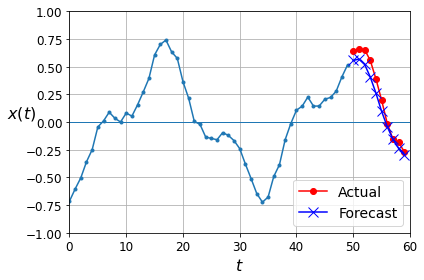

In [31]:

def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()


RNN을 훈련하여 다음 값 10개를 한번에 예측

In [32]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [33]:
# model = keras.models.Sequential([
#     keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None,1]),
#     keras.layers.SimpleRNN(20),
#     keras.layers.Dense(10)
# ])

# model.compile(loss="mse", optimizer="adam")
# history = model.fit(X_train ,Y_train, epochs=20, validation_data=(X_valid, Y_valid))
# model.save("sequence_multiple_forecast_Dense.h5")

Epoch 1/20
219/219 [==============================] - 15s 70ms/step - loss: 0.0557 - val_loss: 0.0258
Epoch 2/20
219/219 [==============================] - 16s 71ms/step - loss: 0.0232 - val_loss: 0.0183
Epoch 3/20
219/219 [==============================] - 16s 72ms/step - loss: 0.0165 - val_loss: 0.0139
Epoch 4/20
219/219 [==============================] - 16s 72ms/step - loss: 0.0144 - val_loss: 0.0130
Epoch 5/20
219/219 [==============================] - 16s 73ms/step - loss: 0.0133 - val_loss: 0.0112
Epoch 6/20
219/219 [==============================] - 15s 70ms/step - loss: 0.0121 - val_loss: 0.0107
Epoch 7/20
219/219 [==============================] - 16s 71ms/step - loss: 0.0117 - val_loss: 0.0119
Epoch 8/20
219/219 [==============================] - 15s 69ms/step - loss: 0.0111 - val_loss: 0.0098
Epoch 9/20
219/219 [==============================] - 16s 73ms/step - loss: 0.0108 - val_loss: 0.0120
Epoch 10/20
219/219 [==============================] - 15s 69ms/step - loss: 0.010

In [36]:
model = keras.models.load_model("sequence_multiple_forecast_Dense.h5")


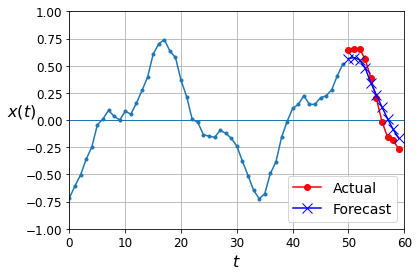

In [37]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Sequence To Sequence


In [38]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [39]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None,1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))


Epoch 1/20
219/219 [==============================] - 16s 74ms/step - loss: 0.0508 - last_time_step_mse: 0.0400 - val_loss: 0.0429 - val_last_time_step_mse: 0.0324
Epoch 2/20
219/219 [==============================] - 16s 73ms/step - loss: 0.0395 - last_time_step_mse: 0.0283 - val_loss: 0.0351 - val_last_time_step_mse: 0.0243
Epoch 3/20
219/219 [==============================] - 16s 73ms/step - loss: 0.0323 - last_time_step_mse: 0.0211 - val_loss: 0.0301 - val_last_time_step_mse: 0.0182
Epoch 4/20
219/219 [==============================] - 16s 73ms/step - loss: 0.0294 - last_time_step_mse: 0.0181 - val_loss: 0.0284 - val_last_time_step_mse: 0.0162
Epoch 5/20
219/219 [==============================] - 16s 73ms/step - loss: 0.0275 - last_time_step_mse: 0.0157 - val_loss: 0.0257 - val_last_time_step_mse: 0.0134
Epoch 6/20
219/219 [==============================] - 16s 74ms/step - loss: 0.0252 - last_time_step_mse: 0.0127 - val_loss: 0.0258 - val_last_time_step_mse: 0.0131
Epoch 7/20
219/2

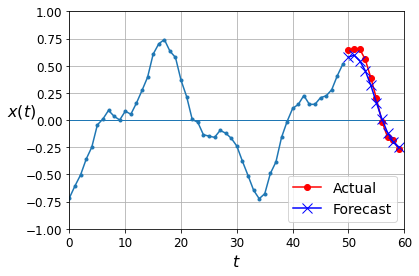

In [44]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# 15.4 긴 시퀀스 다루기

## Deep RNNs with Layer Normalization

In [46]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [47]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None,1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid,Y_valid))

Epoch 1/20
219/219 [==============================] - 41s 186ms/step - loss: 0.1597 - accuracy: 0.2468 - val_loss: 0.0730 - val_accuracy: 0.3398
Epoch 2/20
219/219 [==============================] - 39s 180ms/step - loss: 0.0639 - accuracy: 0.3775 - val_loss: 0.0572 - val_accuracy: 0.3987
Epoch 3/20
219/219 [==============================] - 40s 185ms/step - loss: 0.0536 - accuracy: 0.4301 - val_loss: 0.0499 - val_accuracy: 0.4479
Epoch 4/20
219/219 [==============================] - 38s 174ms/step - loss: 0.0471 - accuracy: 0.4571 - val_loss: 0.0453 - val_accuracy: 0.4580
Epoch 5/20
219/219 [==============================] - 40s 181ms/step - loss: 0.0424 - accuracy: 0.4753 - val_loss: 0.0407 - val_accuracy: 0.4742
Epoch 6/20
219/219 [==============================] - 41s 188ms/step - loss: 0.0391 - accuracy: 0.4902 - val_loss: 0.0369 - val_accuracy: 0.4957
Epoch 7/20
219/219 [==============================] - 41s 186ms/step - loss: 0.0362 - accuracy: 0.5038 - val_loss: 0.0344 - val_ac

## 15.4.2 단기 기억 문제 해결하기
### LSTM

In [54]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None,1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0760 - accuracy: 0.3807 - val_loss: 0.0554 - val_accuracy: 0.4499
Epoch 2/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0480 - accuracy: 0.4791 - val_loss: 0.0427 - val_accuracy: 0.4927
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0391 - accuracy: 0.5045 - val_loss: 0.0367 - val_accuracy: 0.4893
Epoch 4/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0350 - accuracy: 0.5208 - val_loss: 0.0334 - val_accuracy: 0.5187
Epoch 5/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0325 - accuracy: 0.5372 - val_loss: 0.0314 - val_accuracy: 0.5449
Epoch 6/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0308 - accuracy: 0.5499 - val_loss: 0.0298 - val_accuracy: 0.5546
Epoch 7/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0297 - accuracy: 0.5597 - val_loss: 0.0291 - val_accuracy: 0.5640
Epoch 

63/63 [==============================] - 0s 3ms/step - loss: 0.0238 - accuracy: 0.5991


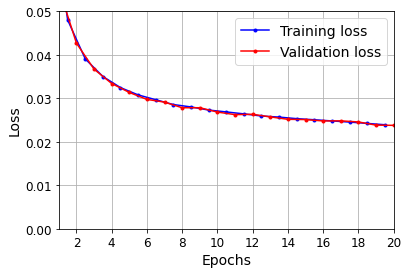

In [55]:
model.evaluate(X_valid, Y_valid)
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

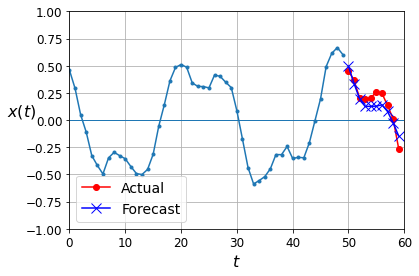

In [56]:

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]


plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

### GRUs

In [57]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None,1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train,Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0738 - last_time_step_mse: 0.0655 - val_loss: 0.0538 - val_last_time_step_mse: 0.0450
Epoch 2/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0476 - last_time_step_mse: 0.0367 - val_loss: 0.0441 - val_last_time_step_mse: 0.0326
Epoch 3/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0417 - last_time_step_mse: 0.0301 - val_loss: 0.0390 - val_last_time_step_mse: 0.0275
Epoch 4/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0368 - last_time_step_mse: 0.0243 - val_loss: 0.0339 - val_last_time_step_mse: 0.0202
Epoch 5/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0326 - last_time_step_mse: 0.0180 - val_loss: 0.0312 - val_last_time_step_mse: 0.0164
Epoch 6/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0306 - last_time_step_mse: 0.0155 - val_loss: 0.0294 - val_last_time_step_mse: 0.0143
Epoch 7/20
219/219 [========

63/63 [==============================] - 0s 3ms/step - loss: 0.0238 - last_time_step_mse: 0.0103


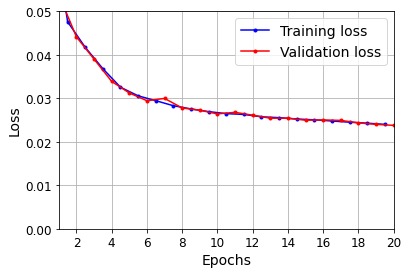

In [58]:
model.evaluate(X_valid, Y_valid)
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

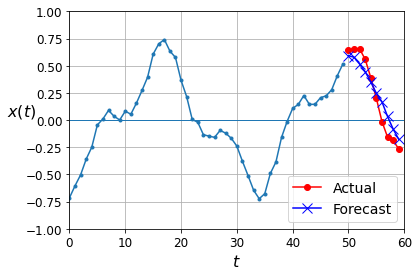

In [59]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

### 1D 합성곱층을 사용해 시퀀스 처리하기

In [61]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid", input_shape=[None,1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20,return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:,3::2], epochs=20,validation_data=(X_valid,Y_valid[:,3::2]))

Epoch 1/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0681 - last_time_step_mse: 0.0601 - val_loss: 0.0477 - val_last_time_step_mse: 0.0396
Epoch 2/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0414 - last_time_step_mse: 0.0340 - val_loss: 0.0367 - val_last_time_step_mse: 0.0285
Epoch 3/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0338 - last_time_step_mse: 0.0257 - val_loss: 0.0307 - val_last_time_step_mse: 0.0218
Epoch 4/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0282 - last_time_step_mse: 0.0184 - val_loss: 0.0259 - val_last_time_step_mse: 0.0152
Epoch 5/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0249 - last_time_step_mse: 0.0143 - val_loss: 0.0246 - val_last_time_step_mse: 0.0141
Epoch 6/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0234 - last_time_step_mse: 0.0125 - val_loss: 0.0227 - val_last_time_step_mse: 0.0115
Epoch 7/20
219/219 [========

### WaveNet

In [62]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None,1]))
for rate in (1,2,4,8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2,padding="causal", activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam",metrics=[last_time_step_mse])

history = model.fit(X_train,Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0668 - last_time_step_mse: 0.0543 - val_loss: 0.0365 - val_last_time_step_mse: 0.0230
Epoch 2/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0323 - last_time_step_mse: 0.0192 - val_loss: 0.0294 - val_last_time_step_mse: 0.0166
Epoch 3/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0283 - last_time_step_mse: 0.0156 - val_loss: 0.0269 - val_last_time_step_mse: 0.0144
Epoch 4/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0261 - last_time_step_mse: 0.0136 - val_loss: 0.0254 - val_last_time_step_mse: 0.0130
Epoch 5/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0248 - last_time_step_mse: 0.0124 - val_loss: 0.0245 - val_last_time_step_mse: 0.0122
Epoch 6/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0239 - last_time_step_mse: 0.0117 - val_loss: 0.0233 - val_last_time_step_mse: 0.0108
Epoch 7/20
219/219 [========

In [66]:
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z

In [67]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_layers_per_block = 3 # 10 in the paper
n_blocks = 1 # 3 in the paper
n_filters = 32 # 128 in the paper
n_outputs = 10 # 256 in the paper

inputs = keras.layers.Input(shape=[None, 1])
z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

In [68]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=2,
                    validation_data=(X_valid, Y_valid))

Epoch 1/2
219/219 [==============================] - 2s 7ms/step - loss: 0.1300 - last_time_step_mse: 0.1260 - val_loss: 0.1229 - val_last_time_step_mse: 0.1199
Epoch 2/2
219/219 [==============================] - 1s 5ms/step - loss: 0.1222 - last_time_step_mse: 0.1178 - val_loss: 0.1217 - val_last_time_step_mse: 0.1189
